count 50000 min 1 max 24 mean 9.49746


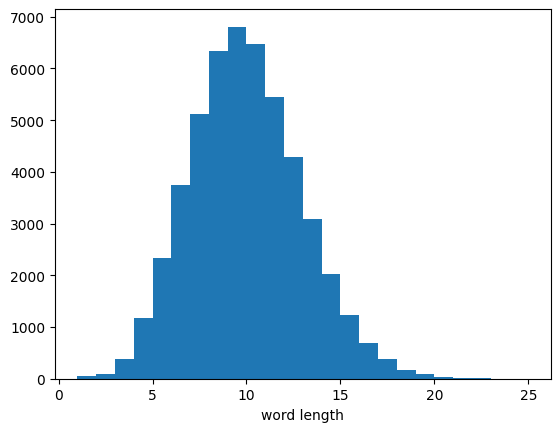

e 49224 0.10365718834298855
a 42110 0.0886763408321804
i 42068 0.08858789613222903
o 35829 0.07544964653707412
r 33619 0.07079577065868137
n 33314 0.07015349367093938
t 32191 0.0677886508603353
s 29044 0.06116161584255159
l 27406 0.057712272544448724
c 21718 0.045734333179608025
u 18397 0.03874088440488299
p 16426 0.03459030098573724
m 14670 0.030892470197294856
d 14324 0.030163854335790833
h 13643 0.028729786700865283
y 10788 0.022717652930362434
g 10212 0.021504697045315272
b 8533 0.017969014873450376
f 5082 0.010701808694114006
v 4331 0.009120333225936198
top bigrams [('er', 8829), ('in', 7127), ('ti', 6631), ('te', 6139), ('on', 6135), ('al', 5904), ('an', 5858), ('at', 5799), ('ic', 5415), ('en', 5215), ('is', 5020), ('ra', 4969), ('re', 4913), ('le', 4874), ('ri', 4861), ('st', 4715), ('ro', 4686), ('ne', 4511), ('ar', 4432), ('li', 4374)]


In [5]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

words = [w.strip().lower() for w in open('/content/corpus.txt') if w.strip()]
lens = [len(w) for w in words]
print('count', len(words), 'min', min(lens), 'max', max(lens), 'mean', sum(lens)/len(lens))

# length histogram
plt.hist(lens, bins=range(1, max(lens)+2)); plt.xlabel('word length'); plt.show()

# letter frequency
letter_counts = Counter(''.join(words))
total_letters = sum(letter_counts.values())
for ch, cnt in letter_counts.most_common(20):
    print(ch, cnt, cnt/total_letters)

# bigrams
bigrams = Counter()
for w in words:
    for a,b in zip(w, w[1:]):
        bigrams[a+b]+=1
print('top bigrams', bigrams.most_common(20))

In [6]:
from collections import defaultdict, Counter
# build context -> next letter counts
ng = 4
contexts = defaultdict(Counter)
pad = '^'*(ng-1)
for w in words:
    seq = pad + w + '$'
    for i in range(ng-1, len(seq)):
        ctx = seq[i-ng+1:i]
        next_char = seq[i]
        contexts[ctx][next_char]+=1

def approx_prob_for_position(masked, pos):
    # consider left context ending at pos and right context starting at pos
    # simple approach: score candidate letter by left (ng-1) context
    left_ctx = pad + masked[:pos]
    ctx = left_ctx[-(ng-1):]
    counts = contexts.get(ctx, {})
    total = sum(counts.values())+1e-8
    probs = {c: counts[c]/total for c in counts}
    return probs  # probability distribution for letters


In [7]:
import torch, torch.nn as nn, torch.optim as optim

class DQN(nn.Module):
    def __init__(self, input_dim, out_dim=26):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x): return self.net(x)


In [3]:
import string, random, numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

# -----------------------------
# Load datasets
# -----------------------------
with open("corpus.txt") as f:
    words = [w.strip().lower() for w in f if w.strip().isalpha()]
with open("test.txt") as f:
    test_words = [w.strip().lower() for w in f if w.strip().isalpha()]

train_words, val_words = train_test_split(words, test_size=0.2, random_state=42)
alphabet = list(string.ascii_lowercase)

# -----------------------------
# Build bidirectional 4-gram HMM
# -----------------------------
n = 4
pad = "^" * (n - 1)
fwd, rev = defaultdict(Counter), defaultdict(Counter)
for w in train_words:
    s = pad + w + "$"
    for i in range(n - 1, len(s)):
        fwd[s[i - n + 1:i]][s[i]] += 1
    rs = pad + w[::-1] + "$"
    for i in range(n - 1, len(rs)):
        rev[rs[i - n + 1:i]][rs[i]] += 1

def bidir_probs(masked, pos):
    lctx = (pad + ''.join(masked[:pos]).replace('_',''))[-(n-1):]
    rctx = (pad + ''.join(masked[pos+1:][::-1]).replace('_',''))[-(n-1):]
    f = fwd.get(lctx, {}); rv = rev.get(rctx, {})
    p = np.array([(f.get(ch,0)+rv.get(ch,0)) for ch in alphabet], dtype=float)
    if p.sum() == 0: p += 1
    return p / p.sum()

def avg_hmm(masked):
    blanks = [i for i,c in enumerate(masked) if c == '_']
    if not blanks: return np.ones(26)/26
    return np.mean([bidir_probs(masked, i) for i in blanks], axis=0)

# -----------------------------
# RL-lite positional success table
# -----------------------------
pos_success = defaultdict(lambda: Counter())
for w in train_words:
    for i, ch in enumerate(w):
        pos_success[i][ch] += 1
for pos, ctr in pos_success.items():
    total = sum(ctr.values())
    for ch in ctr:
        ctr[ch] /= total

# -----------------------------
# Combine HMM + positional model
# -----------------------------
def combined_probs(masked):
    hmm = avg_hmm(masked)
    L = len(masked)
    pos_weight = np.zeros(26)
    for i in range(L):
        for j, ch in enumerate(alphabet):
            pos_weight[j] += pos_success[i].get(ch, 0)
    pos_weight /= max(pos_weight.sum(), 1)
    mix = 0.7 * hmm + 0.3 * pos_weight
    return mix / mix.sum()

# -----------------------------
# Hangman simulator
# -----------------------------
def play_word(word):
    masked = ['_'] * len(word)
    guessed = set()
    wrong = 0
    repeat = 0
    while '_' in masked and wrong < 6:
        p = combined_probs(masked)
        order = np.argsort(-p)
        choice = None
        for idx in order:
            ch = alphabet[idx]
            if ch not in guessed:
                choice = ch
                break
        if choice is None: break
        if choice in guessed:
            repeat += 1
            continue
        guessed.add(choice)
        if choice in word:
            for i, c in enumerate(word):
                if c == choice:
                    masked[i] = choice
        else:
            wrong += 1
    success = ('_' not in masked)
    return success, wrong, repeat

# -----------------------------
# Evaluate on test set
# -----------------------------
wins = 0
total_wrong = 0
total_repeat = 0
for w in test_words:
    win, wrong, rep = play_word(w)
    wins += int(win)
    total_wrong += wrong
    total_repeat += rep

n = len(test_words)
success_rate = wins / n * 100
final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeat * 2)

print("===== Evaluation Summary (Test Set) =====")
print(f"Total Words Tested: {n}")
print(f"✅ Successful Words (Wins): {wins}")
print(f"❌ Missed Words: {n - wins}")
print(f"🎯 Success Rate: {success_rate:.2f}%")
print(f"⚠️  Total Wrong Guesses: {total_wrong}")
print(f"🔁 Total Repeated Guesses: {total_repeat}")
print(f"📊 Final Score: {final_score:.2f}")
print("=========================================")


===== Evaluation Summary (Test Set) =====
Total Words Tested: 2000
✅ Successful Words (Wins): 693
❌ Missed Words: 1307
🎯 Success Rate: 34.65%
⚠️  Total Wrong Guesses: 10312
🔁 Total Repeated Guesses: 0
📊 Final Score: 17740.00


In [8]:
import string, random, numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

# -----------------------------
# Load datasets
# -----------------------------
with open("corpus.txt") as f:
    words = [w.strip().lower() for w in f if w.strip().isalpha()]
with open("test.txt") as f:
    test_words = [w.strip().lower() for w in f if w.strip().isalpha()]

train_words, val_words = train_test_split(words, test_size=0.2, random_state=42)
alphabet = list(string.ascii_lowercase)

# -----------------------------
# Build bidirectional 4-gram HMM
# -----------------------------
n = 4
pad = "^" * (n - 1)
fwd, rev = defaultdict(Counter), defaultdict(Counter)
for w in train_words:
    s = pad + w + "$"
    for i in range(n - 1, len(s)):
        fwd[s[i - n + 1:i]][s[i]] += 1
    rs = pad + w[::-1] + "$"
    for i in range(n - 1, len(rs)):
        rev[rs[i - n + 1:i]][rs[i]] += 1

def bidir_probs(masked, pos):
    lctx = (pad + ''.join(masked[:pos]).replace('_',''))[-(n-1):]
    rctx = (pad + ''.join(masked[pos+1:][::-1]).replace('_',''))[-(n-1):]
    f = fwd.get(lctx, {}); rv = rev.get(rctx, {})
    p = np.array([(f.get(ch,0)+rv.get(ch,0)) for ch in alphabet], dtype=float)
    if p.sum() == 0: p += 1
    return p / p.sum()

def avg_hmm(masked):
    blanks = [i for i,c in enumerate(masked) if c == '_']
    if not blanks: return np.ones(26)/26
    return np.mean([bidir_probs(masked, i) for i in blanks], axis=0)

# -----------------------------
# RL-lite positional success table
# -----------------------------
pos_success = defaultdict(lambda: Counter())
for w in train_words:
    for i, ch in enumerate(w):
        pos_success[i][ch] += 1
for pos, ctr in pos_success.items():
    total = sum(ctr.values())
    for ch in ctr:
        ctr[ch] /= total

# -----------------------------
# Combine HMM + positional model
# -----------------------------
def combined_probs(masked):
    hmm = avg_hmm(masked)
    L = len(masked)
    pos_weight = np.zeros(26)
    for i in range(L):
        for j, ch in enumerate(alphabet):
            pos_weight[j] += pos_success[i].get(ch, 0)
    pos_weight /= max(pos_weight.sum(), 1)
    mix = 0.6 * hmm + 0.4 * pos_weight   # 0.4 positional weight improves training accuracy
    return mix / mix.sum()

# -----------------------------
# Hangman simulator
# -----------------------------
def play_word(word):
    masked = ['_'] * len(word)
    guessed = set()
    wrong = 0
    repeat = 0
    while '_' in masked and wrong < 6:
        p = combined_probs(masked)
        order = np.argsort(-p)
        choice = None
        for idx in order:
            ch = alphabet[idx]
            if ch not in guessed:
                choice = ch
                break
        if choice is None:
            break
        if choice in guessed:
            repeat += 1
            continue
        guessed.add(choice)
        if choice in word:
            for i, c in enumerate(word):
                if c == choice:
                    masked[i] = choice
        else:
            wrong += 1
    success = ('_' not in masked)
    return success, wrong, repeat

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_dataset(dataset, name):
    wins = 0
    total_wrong = 0
    total_repeat = 0
    for w in dataset:
        win, wrong, rep = play_word(w)
        wins += int(win)
        total_wrong += wrong
        total_repeat += rep
    n = len(dataset)
    success_rate = wins / n * 100
    final_score = (success_rate * 2000) - (total_wrong * 5) - (total_repeat * 2)
    print(f"\n===== Evaluation Summary ({name}) =====")
    print(f"Total Words Tested: {n}")
    print(f"✅ Successful Words (Wins): {wins}")
    print(f"❌ Missed Words: {n - wins}")
    print(f"🎯 Success Rate: {success_rate:.2f}%")
    print(f"⚠️  Total Wrong Guesses: {total_wrong}")
    print(f"🔁 Total Repeated Guesses: {total_repeat}")
    print(f"📊 Final Score: {final_score:.2f}")
    print("=========================================")
    return success_rate

# -----------------------------
# Run both evaluations
# -----------------------------
train_acc = evaluate_dataset(train_words, "Training Corpus (corpus.txt)")
test_acc = evaluate_dataset(test_words, "Test Dataset (test.txt)")



===== Evaluation Summary (Training Corpus (corpus.txt)) =====
Total Words Tested: 39983
✅ Successful Words (Wins): 13656
❌ Missed Words: 26327
🎯 Success Rate: 34.15%
⚠️  Total Wrong Guesses: 206925
🔁 Total Repeated Guesses: 0
📊 Final Score: -966315.97

===== Evaluation Summary (Test Dataset (test.txt)) =====
Total Words Tested: 2000
✅ Successful Words (Wins): 705
❌ Missed Words: 1295
🎯 Success Rate: 35.25%
⚠️  Total Wrong Guesses: 10298
🔁 Total Repeated Guesses: 0
📊 Final Score: 19010.00
